In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import time
from collections import Counter
import math
import os
import pickle
import warnings
warnings.filterwarnings("ignore")
import openpyxl

In [2]:
#Reading the pickle files
pick2=r'C:\Users\smahm\Desktop\Courses\Research\EXP\NF'

with open(os.path.join(pick2, 'summaryMar.pickle'), 'rb') as handle:
    march = pickle.load(handle)
with open(os.path.join(pick2, 'summarySep.pickle'), 'rb') as handle:
    september = pickle.load(handle)
with open(os.path.join(pick2, 'summaryNov.pickle'), 'rb') as handle:
    november = pickle.load(handle)

pick3=r'C:\Users\smahm\Desktop\Courses\Research\EXP\FV'

with open(os.path.join(pick3, 'summaryDec.pickle'), 'rb') as handle:
    december = pickle.load(handle)
with open(os.path.join(pick3, 'summaryJan.pickle'), 'rb') as handle:
    january = pickle.load(handle)
with open(os.path.join(pick3, 'summaryAug.pickle'), 'rb') as handle:
    august = pickle.load(handle)

In [3]:
#Finding the occurence of nascent mRNA in "mytime" in given "mydict"
def nas_freq(mytime,mydict):
    '''computing the frequency of active alleles for each time points
    Input:
    mytime: the time point that we are going to compute the frequency (integer)
    mydict: the dictionery containing the result of image processing
    
    Output:
    Numpy array of Qis
    '''
    o=[]
    for i,name in enumerate(list(mydict.keys())):
        if(("time"+str(mytime)+"field") in name):
            o.append(i)
    l=[]
    m=[]
    for k,j in enumerate(o):
        l.append(len(mydict[list(mydict.keys())[j]]))
        for f in range(l[k]):
            if (('nuc'+str(f+1)) in (mydict[list(mydict.keys())[j]]).keys()):
                m.append(mydict[list(mydict.keys())[j]]['nuc'+str(f+1)]['Nnascent'])
    return np.array(m)
#Getting the occeurence or frequency table of a given dictionary
def table_occur(mydict,freq=False,tmin=0,tmax=135):
        '''computing the table of frequency (occurrence) of active alleles for all time points
    Input:
    tmin: the first time point of the table (integer)
    tmax: the last time point of the table (integer)
    mydict: the dictionery containing the result of image processing
    freq: whether the function returns the frequency or the number of nuclei with "i" actgive alleles
    
    Output:
    Table of Qis (pandas data frame) possibly with more than 5 rows (due to error or some biological)
    '''
    df=pd.DataFrame()
    for t in range(tmin,tmax,15):
        df=pd.concat([df,pd.DataFrame.from_dict(Counter(nas_freq(t,mydict)),orient='index',columns=[t])],axis=1,sort=True)
        df=(df.fillna(0)).astype(int)
    if (freq==False):
        return (df)
    if(freq==True):
        return ((df/df.sum()).round(2))

In [4]:
def fourrows(mydict,freq=True,tmin=0,tmax=135):
            '''computing the table of frequency (occurrence) of active alleles 
            for all time points restricted to 4 activation
    Input:
    tmin: the first time point of the table (integer)
    tmax: the last time point of the table (integer)
    mydict: the dictionery containing the result of image processing
    freq: whether the function returns the frequency or the number of nuclei with "i" actgive alleles
    
    Output:
    Table of Qis restricting to the nuclei with maximum 4 active alleles (pandas data frame with 5 rows)
    '''
    df=table_occur(mydict,tmin=tmin,tmax=tmax)
    newdf=df[0:5]
    
    if freq==True:
        newdf=(newdf/newdf.sum()).astype(float).round(2)
        for i in newdf.columns:
            newdf[i][4]=1-(sum(newdf[i][0:4]))
        return newdf.astype(float).round(2)
        
    else:
        return newdf

In [6]:
#Data Frame columns should be time and the rows should be Qis.
def smooth(mydf):
    '''
    smoothing the curve of frequency 
    Input:
    Pandas data frame 
    
    Output:
    Pandas data frame
    '''
    n=len(mydf.columns)
    newdf=pd.DataFrame(index=mydf.index,columns=mydf.columns)
    for i in range(n):
        if(i==0):
            newdf.iloc[:,i]=(0.75*mydf.iloc[:,i])+(0.25*mydf.iloc[:,i+1])
        elif(i==n-1):
            newdf.iloc[:,i]=(0.25*mydf.iloc[:,i-1])+(0.75*mydf.iloc[:,i])
        elif(i!=0 and i!=n-1):
            newdf.iloc[:,i]=(0.25*mydf.iloc[:,i-1])+(0.5*mydf.iloc[:,i])+(0.25*mydf.iloc[:,i+1])
    newdf=newdf/newdf.sum()
    return newdf.round(2)
def prob_single_allele(newdf):
        '''
    Computing the probability of activation for a single allele 
    Input:
    Table of the frequency (pandas data frame with 5 rows)
    
    Output:
    Pandas data frame with a single row
    '''
    newdf=newdf/newdf.sum()
    single_allele=pd.DataFrame(index=[1],columns=newdf.columns)
    for i in newdf.columns:
        single_allele[i][1]=np.round(((newdf[i][1]/4)+(newdf[i][2]/2)+((3*newdf[i][3])/4)+newdf[i][4]),2)
    return single_allele
def JP(df):
        '''
        Computing the joint probability of activation for a pair of alleles
    Input:
    Table of the frequency (pandas data frame with 5 rows)
    
    Output:
    an array
    '''
    jp=[]
    for i in df.columns:
        jp.append(np.round((df[i][2]/6) + (df[i][3]/2) + df[i][4],2))
    return jp

In [7]:
def xlogx(df):
    '''
    extending the function of "xlog(x) to x=0"
    '''
    if type(df)==pd.DataFrame:
        newdf=pd.DataFrame(columns=df.columns,index=df.index)
        for i in range(newdf.shape[0]):
            for j in range(newdf.shape[1]):
                if df.iloc[i,j]==0:
                    newdf.iloc[i,j]=0
                else:
                    newdf.iloc[i,j]=df.iloc[i,j]*np.log(df.iloc[i,j])
        return newdf
    elif type(df)==pd.Series:
        newdf=[]
        for i in df:
            if i==0:
                newdf.append(0)
            elif i>0:
                newdf.append(i*np.log(i))
        return newdf
                
            
def mutualinfo(df):
    '''
    computing the mutual information from table of frequency
    
    Input:
    Table of the frequency (pandas data frame with 5 rows)
    
    Output:
    mutual information (numpy array)
    '''
    mutual=[]
    for i in df.columns:
        R=pd.DataFrame(columns=np.arange(2),index=np.arange(2))
        R.iloc[0,0]=df[i][0] + (df[i][1]/2) + (df[i][2]/6)
        R.iloc[0,1]=(df[i][1]/4) + (df[i][2]/3) + (df[i][3]/4)
        R.iloc[1,0]=R.iloc[0,1]
        R.iloc[1,1]= (df[i][2]/6) + (df[i][3]/2) + df[i][4]
        qY= (R.sum())
        pX= (R.T.sum()) 
        v= xlogx(qY) 
        hY= -sum(v)
        w= xlogx(pX) 
        hX= -sum(w)
        r= xlogx(R) 
        hXY= -sum(r.sum())
        mut = hX + hY - hXY
        mutual.append(np.round(mut,2))
    return mutual

In [9]:
MAR=fourrows(march,tmin=0,tmax=135)
SEP=fourrows(september,tmin=0,tmax=135)
NOV=fourrows(november,tmin=15,tmax=105)

DEC=fourrows(december,tmin=0,tmax=105)
JAN=fourrows(january,tmin=0,tmax=105)
AUG=fourrows_aug(august,tmin=15,tmax=105,dosage=10)

In [10]:
PDEC=prob_single_allele(smooth(DEC))
PJAN=prob_single_allele(smooth(JAN))
PAUG=prob_single_allele(smooth(AUG))

PMAR=prob_single_allele(smooth(MAR))
PSEP=prob_single_allele(smooth(SEP))
PNOV=prob_single_allele(smooth(NOV))

In [11]:
SPMAR=(PMAR.iloc[0,1:7])**2
SPSEP=(PSEP.iloc[0,1:7])**2
SPNOV=(PNOV.iloc[0,0:6])**2

SPDEC=(PDEC.iloc[0,1:7])**2
SPJAN=(PJAN.iloc[0,1:7])**2
SPAUG=(PAUG.iloc[0,0:6])**2

In [12]:
FMAR=mutualinfo(MAR)
FSEP=mutualinfo(SEP)
FNOV=mutualinfo(NOV)

FDEC=mutualinfo(DEC)
FJAN=mutualinfo(JAN)
FAUG=mutualinfo(AUG)

In [13]:
JMAR=JP(MAR)
JSEP=JP(SEP)
JNOV=JP(NOV)

JDEC=JP(DEC)
JJAN=JP(JAN)
JAUG=JP(AUG)

In [14]:
myt=[15,30,45,60,75,90]
myt2=[0,15,30,45,60,75,90]
myt3=[str(i) for i in range(15,105,15)]

# Figure 1B

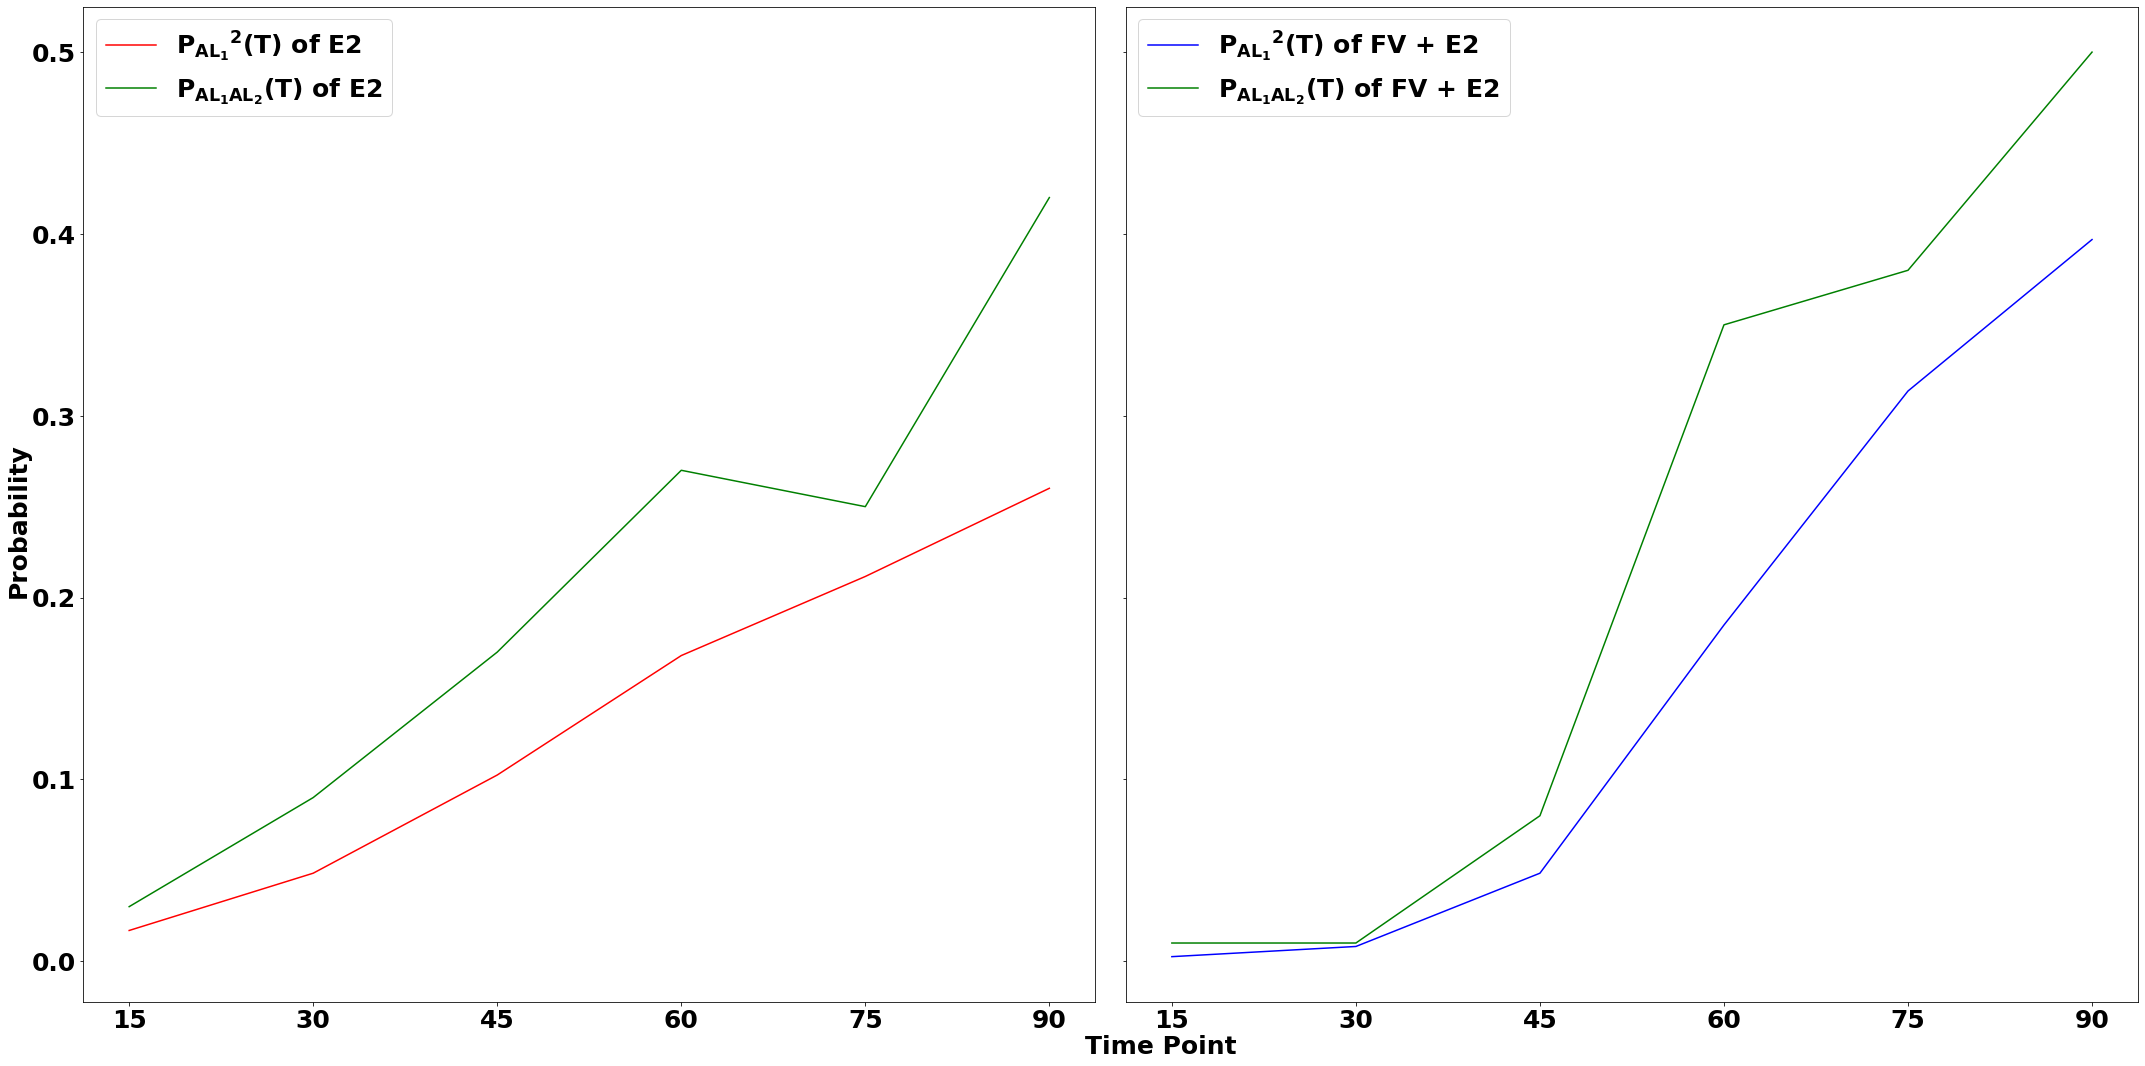

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 15),constrained_layout=False,sharex=True, sharey=True)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.setp(axes,yticks=np.linspace(0, 1, 11,endpoint=True))



axes[0].plot(myt3,(PMAR.iloc[0,1:7])**2,label='$\mathbf{{P_{AL_{1}}}^2 (T)}$ of E2',color='red') 
axes[0].plot(myt3,JMAR[1:7],label='$\mathbf{P_{AL_{1}AL_{2}}(T)}$ of E2',color='green') 
axes[0].legend(loc='upper left')



axes[1].plot(myt3,(PDEC.iloc[0,1:7])**2,label='$\mathbf{{P_{AL_{1}}}^2 (T)}$ of FV + E2',color='Blue') 
axes[1].plot(myt3,JDEC[1:7],label='$\mathbf{P_{AL_{1}AL_{2}}(T)}$ of FV + E2',color='green') 
axes[1].legend(loc='upper left')




fig.tight_layout()

plt.rcParams.update({'font.size': 25})
fig.text(0.5, 0.001, 'Time Point', ha='left', va='bottom') #for x label
fig.text(0.001, 0.5, 'Probability', ha='left', va='center', rotation='vertical')# for y label
plt.show()

# Figure 1B

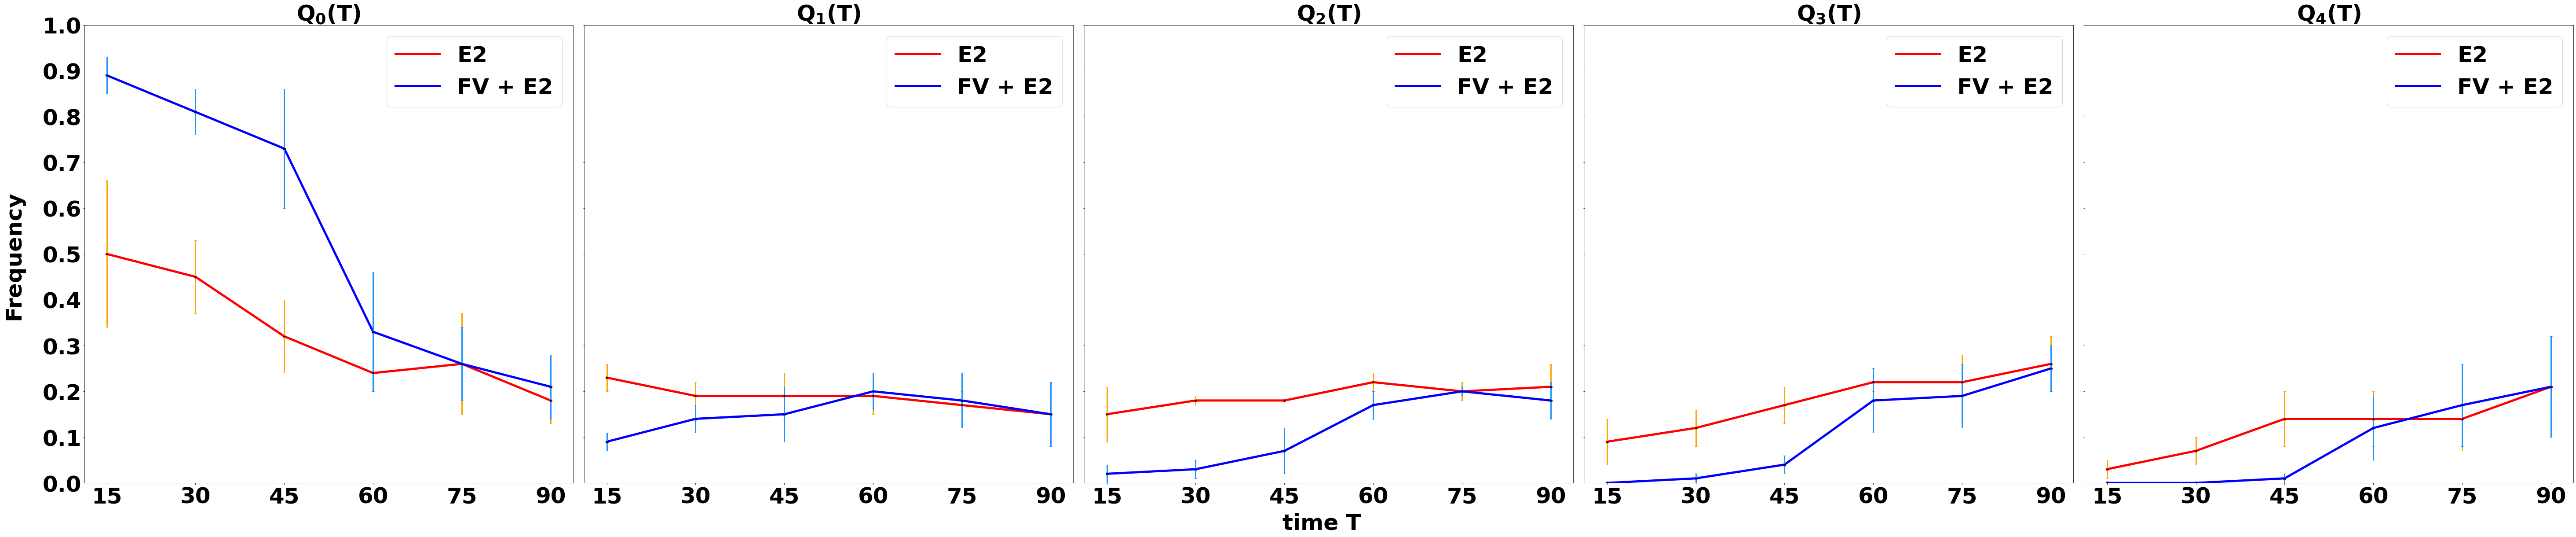

In [76]:
linewidth=5
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rc('axes', labelsize=30) 

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(80, 16),constrained_layout=True,sharex=True, sharey=True)
# fig.suptitle("Fraction of cells with 0,1,2,3 or 4 transcription site(s) at each time T ",y=1.03,fontweight="bold",\
#              fontsize=25 )

plt.setp(axes,yticks=np.linspace(0, 1, 11,endpoint=True))



axes[0].plot(myt3, Q0NFMN,color='red',label='E2',linewidth=linewidth)
axes[0].scatter(myt3, Q0NFMN,color='red')
axes[0].errorbar(myt3, Q0NFMN, yerr=Q0NFSD, fmt='.k',ecolor='orange',\
             elinewidth=3, capsize=3)# ,uplims=upperlimits, lolims=lowerlimits,) 
axes[0].plot(myt3, Q0FVMN,color='blue',label='FV + E2',linewidth=linewidth)
axes[0].scatter(myt3, Q0FVMN,color='blue')
axes[0].errorbar(myt3, Q0FVMN, yerr=Q0FVSD, fmt='.k',ecolor='dodgerblue',\
             elinewidth=3, capsize=3)
axes[0].legend(loc='upper right',prop= {'size': 50})
axes[0].set_title("$\mathbf{Q_{0}}$(T)",fontsize = 50,fontweight="bold" )


axes[1].plot(myt3, Q1NFMN,color='red',label='E2',linewidth=linewidth)
axes[1].scatter(myt3, Q1NFMN,color='red')

axes[1].errorbar(myt3, Q1NFMN, yerr=Q1NFSD, fmt='.k',ecolor='orange',\
             elinewidth=3, capsize=3)# ,uplims=upperlimits, lolims=lowerlimits,) 
axes[1].plot(myt3, Q1FVMN,color='blue',label='FV + E2',linewidth=linewidth)
axes[1].scatter(myt3, Q1FVMN,color='blue')
axes[1].errorbar(myt3, Q1FVMN, yerr=Q1FVSD, fmt='.k',ecolor='dodgerblue',\
             elinewidth=3, capsize=3)
axes[1].legend(loc='upper right',prop= {'size': 50})
axes[1].set_title("$\mathbf{Q_{1}}$(T)",fontsize = 50,fontweight="bold" )


axes[2].plot(myt3, Q2NFMN,color='red',label='E2',linewidth=linewidth)
axes[2].scatter(myt3, Q2NFMN,color='red')

axes[2].errorbar(myt3, Q2NFMN, yerr=Q2NFSD, fmt='.k',ecolor='orange',\
             elinewidth=3, capsize=3)# ,uplims=upperlimits, lolims=lowerlimits,) 
axes[2].plot(myt3, Q2FVMN,color='blue',label='FV + E2',linewidth=linewidth)
axes[2].scatter(myt3, Q2FVMN,color='blue')

axes[2].errorbar(myt3, Q2FVMN, yerr=Q2FVSD, fmt='.k',ecolor='dodgerblue',\
             elinewidth=3, capsize=3)
axes[2].legend(loc='upper right',prop= {'size': 50})
axes[2].set_title("$\mathbf{Q_{2}}$(T)",fontsize = 50,fontweight="bold" )


axes[3].plot(myt3, Q3NFMN,color='red',label='E2',linewidth=linewidth)
axes[3].scatter(myt3, Q3NFMN,color='red')

axes[3].errorbar(myt3, Q3NFMN, yerr=Q3NFSD, fmt='.k',ecolor='orange',\
             elinewidth=3, capsize=3)# ,uplims=upperlimits, lolims=lowerlimits,) 
axes[3].plot(myt3, Q3FVMN,color='blue',label='FV + E2',linewidth=linewidth)
axes[3].scatter(myt3, Q3FVMN,color='blue')

axes[3].errorbar(myt3, Q3FVMN, yerr=Q3FVSD, fmt='.k',ecolor='dodgerblue',\
             elinewidth=3, capsize=3)
axes[3].legend(loc='upper right',prop= {'size': 50})
axes[3].set_title("$\mathbf{Q_{3}}$(T)",fontsize = 50,fontweight="bold" )


axes[4].plot(myt3, Q4NFMN,color='red',label='E2',linewidth=linewidth)
axes[4].scatter(myt3, Q4NFMN,color='red')

axes[4].errorbar(myt3, Q4NFMN, yerr=Q4NFSD, fmt='.k',ecolor='orange',\
             elinewidth=3, capsize=3)# ,uplims=upperlimits, lolims=lowerlimits,) 
axes[4].plot(myt3, Q4FVMN,color='blue',label='FV + E2',linewidth=linewidth)
axes[4].scatter(myt3, Q4FVMN,color='blue')

axes[4].errorbar(myt3, Q4FVMN, yerr=Q4FVSD, fmt='.k',ecolor='dodgerblue',\
             elinewidth=3, capsize=3)
axes[4].legend(loc='upper right',prop= {'size': 50})
axes[4].set_title("$\mathbf{Q_{4}}$(T)",fontsize = 50,fontweight="bold" )

for i in range(5):
    axes[i].tick_params(axis = 'both', which = 'major', labelsize = 50)
    axes[i].tick_params(axis = 'both', which = 'major', labelsize = 50)
#,uplims=lowerlimits, lolims=upperlimits)
plt.ylim([0, 1])
# plt.legend(loc='upper right')
fig.text(0.49, -0.05, 'time T', ha='left', va='bottom',fontsize = 50) #for x label
fig.text(-0.015, 0.5, 'Frequency', ha='left', va='center', rotation='vertical',fontsize = 50)# for y label
# plt.title("Normalized Frequency and its error for Q"+str(i))
# plt.rcParams.update({'font.size': 30})
# plt.rcParams['figure.figsize'] = 10, 10
# plt.title("Fraction of cells with 0,1,2,3 or 4 activation at each time point "  )
# fig.savefig('figure1B.jpg')
# plt.rc('xtick', labelsize=30) 
# plt.rc('ytick', labelsize=30) 
# plt.xticks(fontsize=50)

plt.show()

# Figure 3A

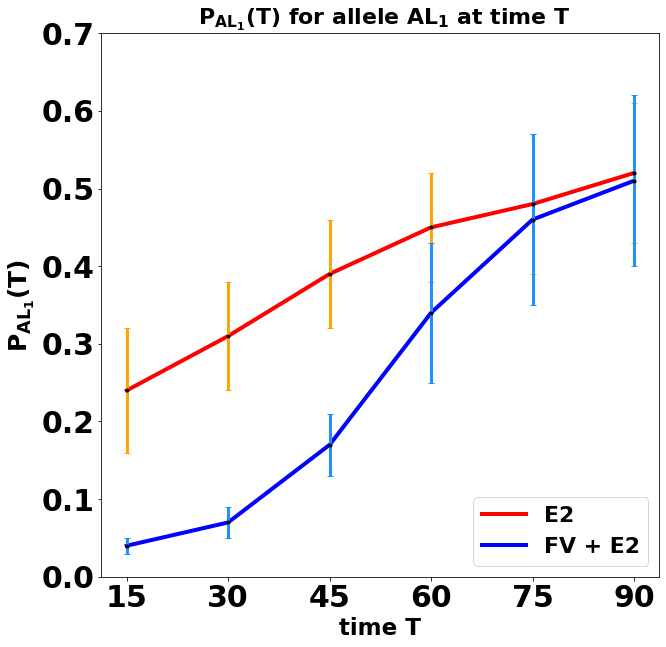

In [90]:
# upperlimits = [True, False] * 3
# lowerlimits = [False, True] * 3
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.plot(myt3, PNFMN,color='red',label='E2',linewidth=4)
plt.errorbar(myt3, PNFMN, yerr=PNFSD, fmt='.k',ecolor='orange',\
             elinewidth=3, capsize=3)# ,uplims=upperlimits, lolims=lowerlimits,)
plt.plot(myt3, PFVMN,color='blue',label='FV + E2',linewidth=4)
plt.errorbar(myt3, PFVMN, yerr=PFVSD, fmt='.k',ecolor='dodgerblue',\
             elinewidth=3, capsize=3)#,uplims=lowerlimits, lolims=upperlimits)
plt.ylim([0, 0.7])
# plt.xlim(range(15,105,15))

plt.legend(loc='lower right',prop= {'size': 22})
plt.ylabel("$\mathbf{P_{AL_{1}}}$(T)",size=25)
plt.xlabel("time T",size=23)
# plt.title("Normalized Frequency and its error for Q"+str(i))
# plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = 10, 10
plt.title(" $\mathbf{P_{AL_{1}}}$(T) for allele $\mathbf{AL_{1}}$ at time T ",fontweight="bold",fontsize=22   )
plt.show()

# Figure 3B

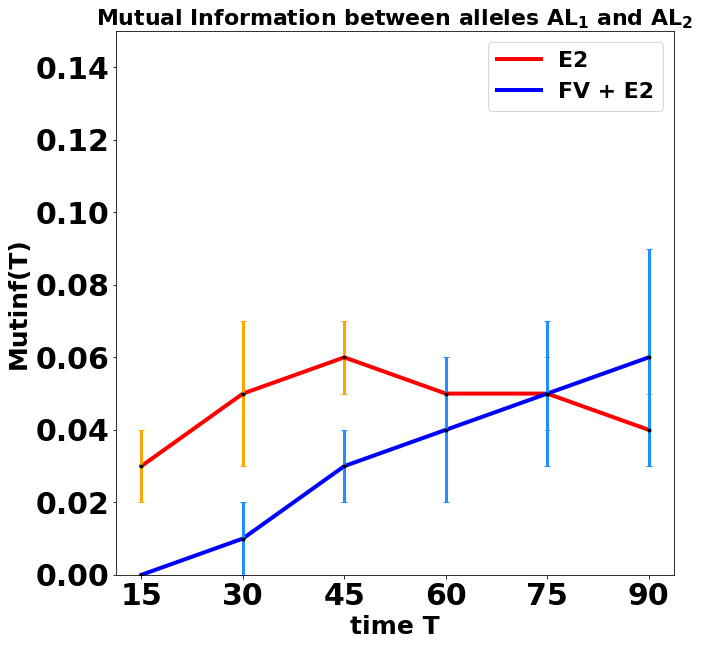

In [135]:
# upperlimits = [True, False] * 3
# lowerlimits = [False, True] * 3
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.plot(myt3, FNFMN,color='red',label='E2',linewidth=4)
plt.errorbar(myt3, FNFMN, yerr=FNFSD, fmt='.k',ecolor='orange',\
             elinewidth=3, capsize=3)# ,uplims=upperlimits, lolims=lowerlimits,)
plt.plot(myt3, FFVMN,color='blue',label='FV + E2',linewidth=4)
plt.errorbar(myt3, FFVMN, yerr=FFVSD, fmt='.k',ecolor='dodgerblue',\
             elinewidth=3, capsize=3)#,uplims=lowerlimits, lolims=upperlimits)
plt.ylim([0, 0.15])
plt.legend(loc='upper right',prop= {'size': 22})
plt.ylabel("Mutinf(T)",size=25)
plt.xlabel("time T",size=25)
# plt.title("Normalized Frequency and its error for Q"+str(i))
# plt.rcParams.update({'font.size': 15})
# plt.rcParams['figure.figsize'] = 10, 10
plt.title("Mutual Information between alleles $\mathbf{AL_{1}}$ and $\mathbf{AL_{2}}$ ",\
          fontweight="bold",fontsize=22  )

plt.show()

# Figure 3C

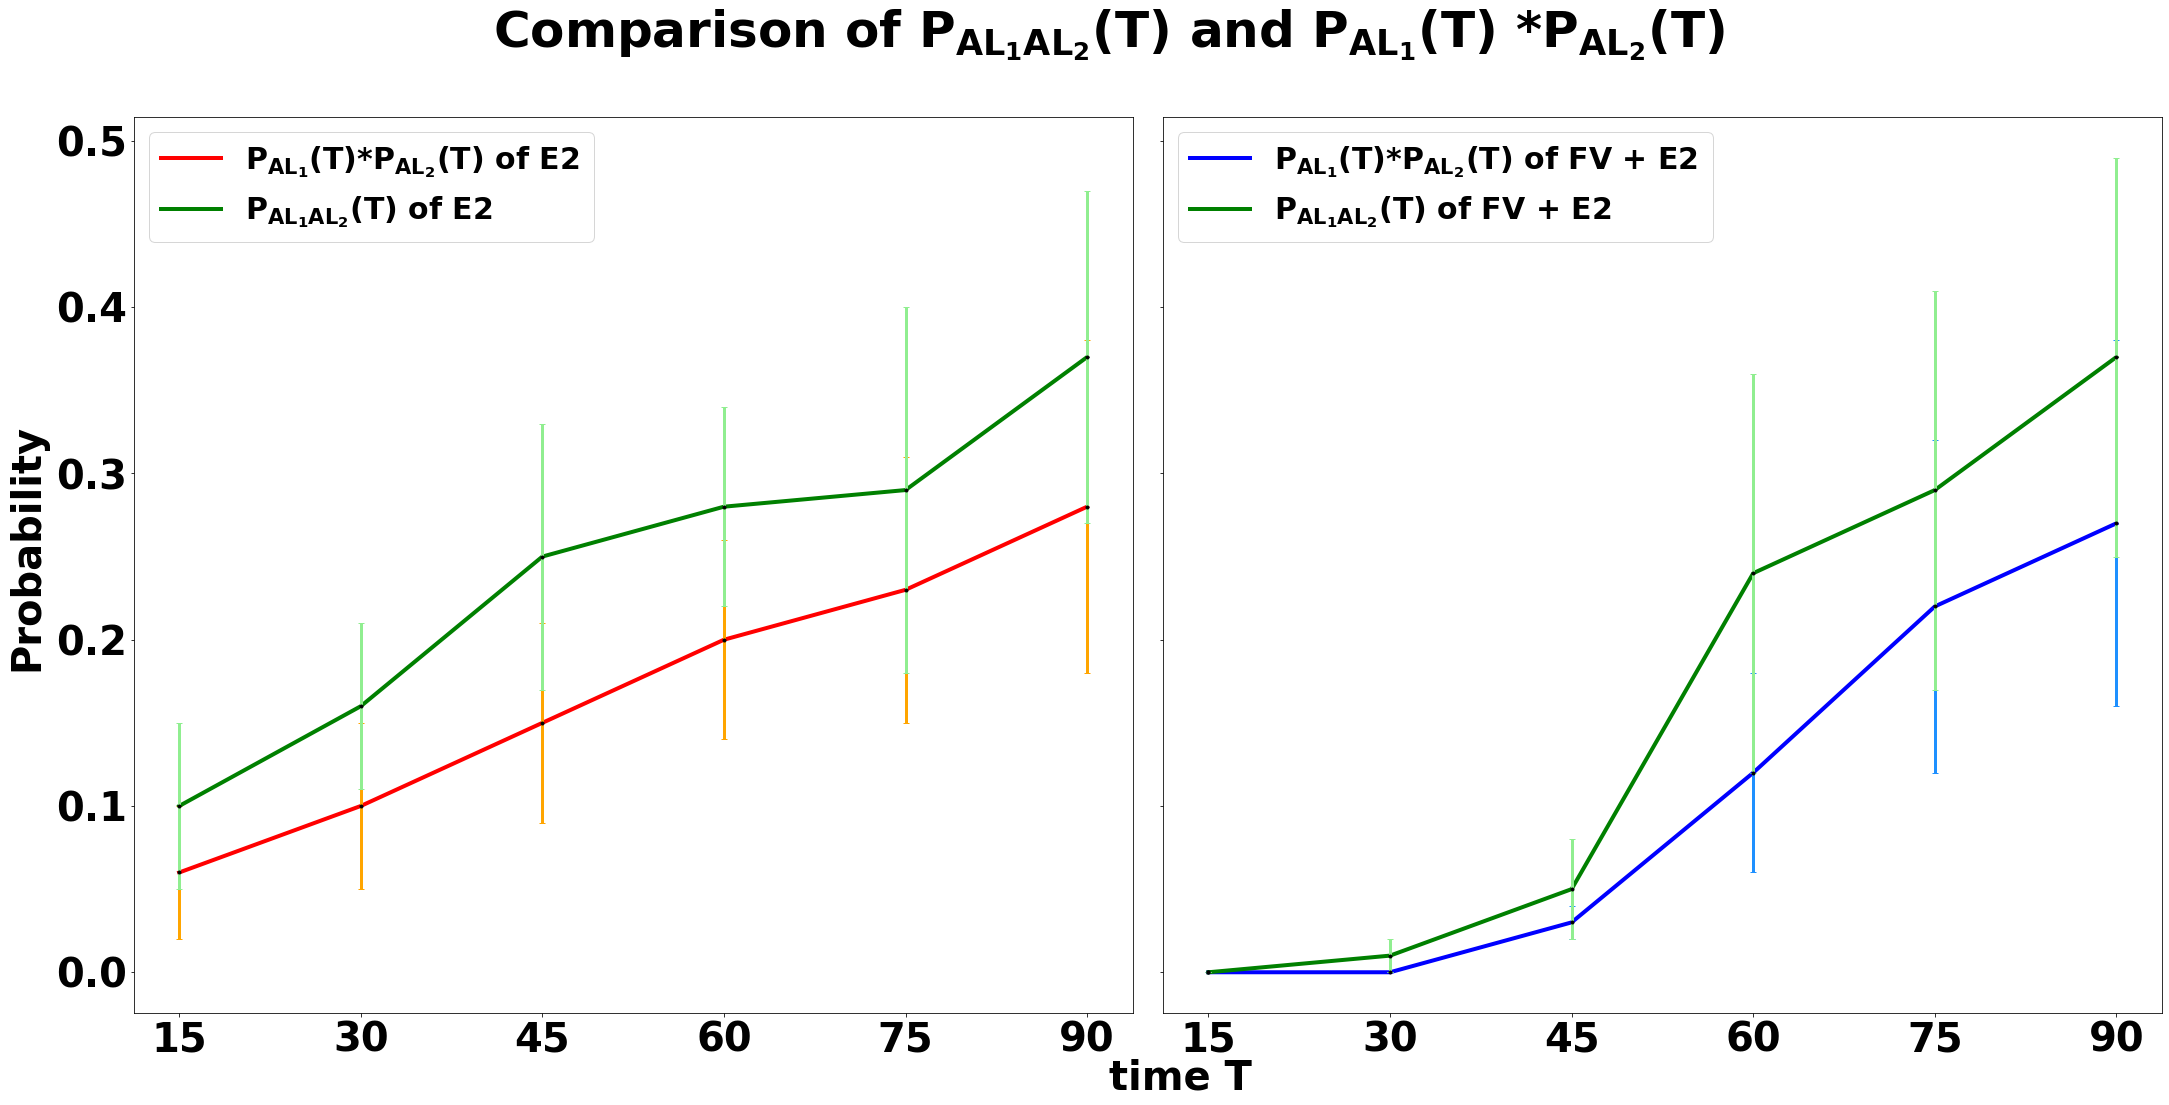

In [130]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 15),constrained_layout=False,sharex=True, sharey=True)
fig.suptitle('Comparison of $\mathbf{P_{AL_{1}AL_{2}}}$(T) and $\mathbf{P_{AL_{1}}}$(T) $* \mathbf{P_{AL_{2}}}$(T)',\
             y=1,fontweight="bold" ,fontsize=50)

plt.setp(axes,yticks=np.linspace(0, 1, 11,endpoint=True))



axes[0].plot(myt3,SPNFMN,color='red',label='$\mathbf{P_{AL_{1}}}$(T)*$\mathbf{P_{AL_{2}}}$(T) of E2 ',linewidth=4)
axes[0].errorbar(myt3, SPNFMN, yerr=SPNFSD, fmt='.k',ecolor='orange',\
             elinewidth=3, capsize=3)
axes[0].plot(myt3,JNFMN,color='green',label='$\mathbf{P_{AL_{1}AL_{2}}}$(T) of E2 ',linewidth=4) 
axes[0].errorbar(myt3, JNFMN, yerr=JNFSD, fmt='.k',ecolor='lightgreen',\
             elinewidth=3, capsize=3)
axes[0].legend(loc='upper left',prop= {'size': 30})

axes[1].plot(myt3,SPFVMN,color='blue',label='$\mathbf{P_{AL_{1}}}$(T)*$\mathbf{P_{AL_{2}}}$(T) of FV + E2 ',linewidth=4) 
axes[1].errorbar(myt3, SPFVMN, yerr=SPFVSD, fmt='.k',ecolor='dodgerblue',\
             elinewidth=3, capsize=3)
axes[1].plot(myt3,JFVMN,color='green',label='$\mathbf{P_{AL_{1}AL_{2}}}$(T) of FV + E2',linewidth=4)#'\mathbf{P_{AL_{1}AL_{2}}}$(T) of FV + E2 ') 
axes[1].errorbar(myt3, JFVMN, yerr=JFVSD, fmt='.k',ecolor='lightgreen',\
             elinewidth=3, capsize=3)
axes[1].legend(loc='upper left',prop= {'size': 30})

for i in range(2):
    axes[i].tick_params(axis = 'both', which = 'major', labelsize = 40)
    axes[i].tick_params(axis = 'both', which = 'major', labelsize = 40)


fig.tight_layout()

# plt.rcParams.update({'font.size': 25})
fig.text(0.5, -0.01, 'time T', ha='left', va='bottom',fontsize = 40) #for x label
fig.text(-0.01, 0.5, 'Probability', ha='left', va='center', rotation='vertical',fontsize = 40)# for y label
plt.show()

# Figure 3D

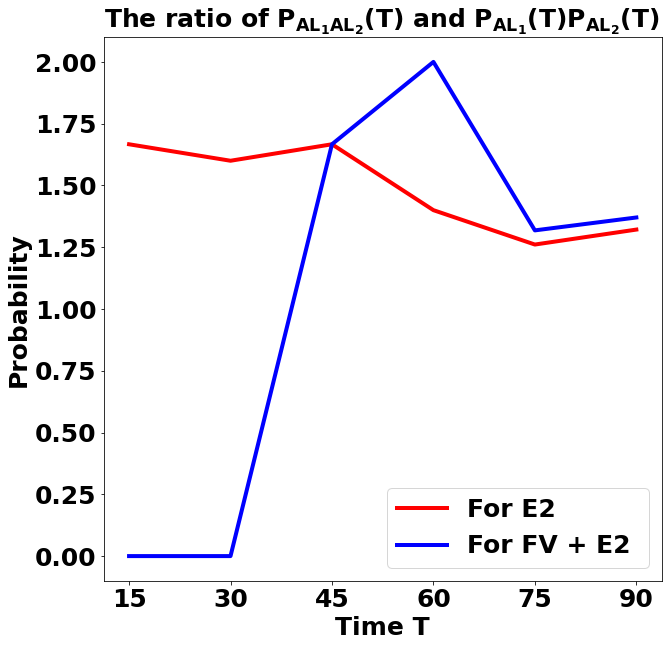

In [134]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.title('The ratio of $\mathbf{P_{AL_{1}AL_{2}}}$(T) and $\mathbf{P_{AL_{1}}}$(T)$\mathbf{P_{AL_{2}}}$(T) ',\
          fontsize=25,fontweight="bold")

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 15),constrained_layout=False,sharex=True, sharey=True)
# fig.suptitle('The ratio of $\mathbf{P_{AL_{1}AL_{2}}}$ and $\mathbf{{P_{AL}}^2}$(T) ',y=1,fontweight="bold" )
# plt.setp(axes,yticks=np.linspace(0, 1, 11,endpoint=True))

# axes[0].plot(myt3,SPNFMN,color='red',label='$\mathbf{{P_{AL}}^2}$(T) of E2 ')
# axes[0].errorbar(myt3, SPNFMN, yerr=SPNFSD, fmt='.k',ecolor='orange',\
#              elinewidth=3, capsize=3)
# axes[0].plot(myt3,np.divide(JNFMN,SPNFMN),color='red',label='For E2 ') 
# axes[0].errorbar(myt3, JNFMN, yerr=JNFSD, fmt='.k',ecolor='lightgreen',\
#              elinewidth=3, capsize=3)
# axes[0].legend(loc='lower right')

plt.plot(myt3,np.divide(JNFMN,SPNFMN),color='red',label='For E2 ',linewidth=4) 


# axes[1].plot(myt3,SPFVMN,color='blue',label='$\mathbf{{P_{AL}}^2}$(T) of FV + E2 ') 
# axes[1].errorbar(myt3, SPFVMN, yerr=SPFVSD, fmt='.k',ecolor='dodgerblue',\
#              elinewidth=3, capsize=3)
FVratio=np.divide(np.array(JFVMN),np.array(SPFVMN))
FVratio[0]=0
FVratio[1]=0
# axes[1].plot(myt3,FVratio,color='blue',label='For FV + E2 ',linewidth=4) 
# axes[1].errorbar(myt3, JFVMN, yerr=JFVSD, fmt='.k',ecolor='lightgreen',\
#              elinewidth=3, capsize=3)
# axes[1].legend(loc='lower right')
plt.plot(myt3,FVratio,color='blue',label='For FV + E2 ',linewidth=4) 

plt.legend(loc='lower right',prop= {'size': 25})
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
plt.ylabel("Probability",size=25)
plt.xlabel("Time T",size=25)


# fig.tight_layout()

plt.rcParams.update({'font.size': 25})
fig.text(0.5, 0.001, 'time T', ha='left', va='bottom',fontsize=25) #for x label
fig.text(0.001, 0.5, 'Probability', ha='left', va='center', rotation='vertical',fontsize=25)# for y label
plt.show()